# Cross-Source Feature Comparisons

In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_seaborn
%matplotlib inline
from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_aggregation import entity
from mgds.data_modeling import data_broker as dbm
from mgds.data_modeling import training01 as rx_train
from mgds.data_modeling import data as feature_data

# AUC Comparison (CTD vs GDSC)

In [2]:
d1 = api.get_raw_genomic_data(src.CTD_v2, dtyp.DRUG_SENSITIVITY)
#d1 = db.load(src.CTD_v2, db.IMPORT, 'drug-sensitivity')
d1.info()

2017-03-20 12:20:37,045:WARNING:mgds.data_aggregation.api: Genomic data for source "ctd_v2" and data type "drug-sensitivity" has a cell line mapping but does not have a primary site mapping (so all primary site fields will be null)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 395263 entries, 0 to 395262
Data columns (total 15 columns):
CELL_LINE_ID           395263 non-null object
CELL_LINE_ID:CTD       395263 non-null int64
DRUG_ID:CTD            395263 non-null int64
SMILES                 395263 non-null object
DRUG_NAME              395263 non-null object
STATUS                 395263 non-null object
DRUG_ID:BROAD          395263 non-null object
AUC                    395263 non-null float64
LOG2_EC50              395263 non-null float64
EXPERIMENT_ID          395263 non-null int64
CELL_LINE_ID:MGDS      395263 non-null object
PRIMARY_SITE:SOURCE    0 non-null object
PRIMARY_SITE:MGDS      0 non-null object
DRUG_NAME:MGDS         395263 non-null object
DRUG_NAME:SOURCE       395263 non-null object
dtypes: float64(2), int64(3), object(10)
memory usage: 48.2+ MB


In [3]:
d2 = api.get_raw_genomic_data(src.GDSC_v2, dtyp.DRUG_SENSITIVITY)
#d2 = db.load(src.GDSC_v2, db.IMPORT, 'drug-sensitivity')
d2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212665 entries, 0 to 212664
Data columns (total 17 columns):
IC50_RESULTS_ID        212665 non-null object
CELL_LINE_ID:COSMIC    212665 non-null object
DRUG_ID:COSMIC         212665 non-null int64
MAX_CONC_MICROMOLAR    212665 non-null float64
LN_IC50                212665 non-null float64
AUC                    212665 non-null float64
RMSE                   212665 non-null float64
DRUG_NAME              212665 non-null object
SYNONYMS               113092 non-null object
TARGET                 211696 non-null object
TARGET_PATHWAY         212665 non-null object
CELL_LINE_ID           205148 non-null object
CELL_LINE_ID:MGDS      205148 non-null object
PRIMARY_SITE:MGDS      205148 non-null object
PRIMARY_SITE:SOURCE    205148 non-null object
DRUG_NAME:MGDS         212665 non-null object
DRUG_NAME:SOURCE       212665 non-null object
dtypes: float64(4), int64(1), object(12)
memory usage: 29.2+ MB


In [4]:
from py_utils import set_utils
set_res = set_utils.analyze_sets(d1['DRUG_NAME:MGDS'].unique(), d2['DRUG_NAME:MGDS'].unique(), items=True)

In [5]:
drugs = set_res['Items']['InBoth']

In [6]:
d1.groupby(['CELL_LINE_ID:MGDS', 'DRUG_NAME:MGDS']).size().value_counts()

1    379422
2      7283
3       425
dtype: int64

In [7]:
d = pd.concat([
    d1.groupby(['CELL_LINE_ID:MGDS', 'DRUG_NAME:MGDS'])['AUC'].mean().rename('AUC:CTD'),
    d2.groupby(['CELL_LINE_ID:MGDS', 'DRUG_NAME:MGDS'])['AUC'].mean().rename('AUC:GDSC'),
], join='inner', axis=1)
d.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 36037 entries, (22RV1, 17AAG) to (ZR7530, VORINOSTAT)
Data columns (total 2 columns):
AUC:CTD     36037 non-null float64
AUC:GDSC    36037 non-null float64
dtypes: float64(2)
memory usage: 674.0+ KB


In [8]:
d.describe()

,AUC:CTD,AUC:GDSC
count,36037.000000,36037.000000
mean,12.064085,0.816141
std,2.655791,0.217821
min,0.069100,0.008591
25%,10.795000,0.738899
50%,12.581000,0.907625
75%,13.968000,0.974089
max,20.000000,0.998639


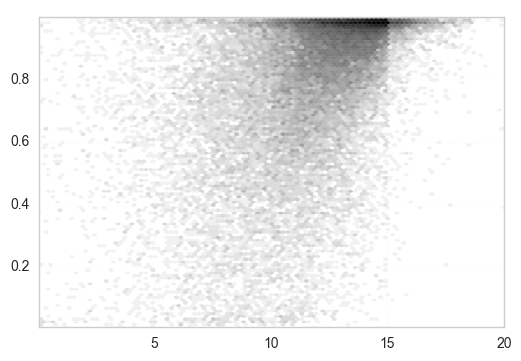

In [12]:
plt.hexbin(d['AUC:CTD'], d['AUC:GDSC'], bins='log')

# TCGA Gene Names vs Other Sources

In [13]:
# Load data from data_modeling/prep/tcga-prep.ipynb
d = db.load_obj(src.TCGA_v1, db.PREP, 'raw-data-matrices')
d.keys()

2017-03-20 14:05:11,755:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"


dict_keys(['gene-rna-seq', 'gene-rppa', 'gene-copy-number', 'gene-methylation', 'gene-exome-seq', 'gene-expression'])

In [14]:
d['gene-expression'].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 529 entries, (brca, TCGA-A1-A0SD-01) to (brca, TCGA-E2-A1BD-01)
Columns: 16810 entries, A1BG to ZZZ3
dtypes: float64(16810)
memory usage: 67.8+ MB


In [ ]:
from py_utils import set_utils

In [20]:
def compare_gene_sets(tcga_dtyp, dat_src, dat_typ):
    d1 = d[tcga_dtyp].columns.tolist()
    d2 = api.get_raw_genomic_data(dat_src, dat_typ)['GENE_ID:HGNC'].unique()
    return set_utils.analyze_sets(d1, d2, items=True)

In [21]:
compare_gene_sets(dtyp.GENE_EXPRESSION, src.CCLE_v1, dtyp.GENE_EXPRESSION)['Stats']

{'All': '18165 (100%)',
 'InBoth': '14687 (80.85%)',
 'InOnlyOne': '3478 (19.15%)',
 'InOnlySet1': '2123 (11.69%)',
 'InOnlySet2': '1355 (7.46%)'}

In [22]:
compare_gene_sets(dtyp.GENE_EXPRESSION, src.GDSC_v2, dtyp.GENE_EXPRESSION)['Stats']

{'All': '19187 (100%)',
 'InBoth': '15042 (78.40%)',
 'InOnlyOne': '4145 (21.60%)',
 'InOnlySet1': '1768 (9.21%)',
 'InOnlySet2': '2377 (12.39%)'}

In [27]:
compare_gene_sets(dtyp.GENE_COPY_NUMBER, src.CCLE_v1, dtyp.GENE_COPY_NUMBER)['Stats']

{'All': '24037 (100%)',
 'InBoth': '19626 (81.65%)',
 'InOnlyOne': '4411 (18.35%)',
 'InOnlySet1': '3656 (15.21%)',
 'InOnlySet2': '755 (3.14%)'}

In [31]:
# d1 = d[dtyp.GENE_EXPRESSION]
# d2 = api.get_raw_genomic_data(src.CCLE_v1, dtyp.GENE_EXPRESSION)